## Code

### Libs

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

from random import choices
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

### Structs

In [65]:
class AdaBoost:
    def __init__(self):
        self.h = []
        self.a = []
        
    def fit(self, X, y, weights):
        classifier = DecisionTreeClassifier(max_depth=2)
        indices = choices(range(len(X)), weights=weights, k=len(X))
        new_X = [X[i] for i in indices]
        new_y = [y[i] for i in indices]
        classifier.fit(new_X, new_y)

        predicted = classifier.predict(X)
        error = sum([weights[i] for i in range(len(X)) if predicted[i] != y[i]])
        alpha = 0.5 * np.log((1 - error) / error) if np.isclose(0, error) else 1
        
        z = 0
        for i in range(len(weights)):
            weights[i] *= np.exp(-alpha * y[i] * predicted[i])
            z += weights[i]
        
        self.h.append(classifier)
        self.a.append(alpha)
        
        return [w / z for w in weights]
    
    def predict(self, X):
        return np.sign(sum([self.a[i] * self.h[i].predict(X) for i in range(len(self.h))]))

### Data Process

In [66]:
def read_data(file_name):
    a = pandas.read_csv(file_name + '.csv')
    return a[['x', 'y']].values.tolist(), [1 if c == 'P' else -1 for c in a['class']]

### Helpers

In [67]:
h, a, weights = None, None, None
boost = AdaBoost()

get_fib_n = lambda n: 0 if n < 0 else 1 if n <= 1 else get_fib_n(n - 1) + get_fib_n(n - 2)
key_steps = [get_fib_n(i) - 1 for i in range(10)][1:]

X_chips, y_chips = read_data('chips')
X_geyser, y_geyser = read_data('geyser')

In [68]:
def prcess_data(name):
    global weights, boost

    X = X_chips if name == 'chips' else X_geyser
    y = y_chips if name == 'chips' else y_geyser

    min_x = min([X[i][0] for i in range(len(X))])
    min_y = min([X[i][1] for i in range(len(X))])
    max_x = max([X[i][0] for i in range(len(X))])
    max_y = max([X[i][1] for i in range(len(X))])

    points_count = 100
    background_X_x = np.linspace(min_x, max_x, points_count)
    background_X_y = np.linspace(min_y, max_y, points_count)
    background_X = [[x, y]
                    for x, y in zip(np.repeat(background_X_x, points_count), np.tile(background_X_y, points_count))]

    weights = [1.0 / len(X)] * len(X)
    steps = 100
    boost = AdaBoost()
    for step in range(1, steps + 1):
        weights = boost.fit(X, y, weights)
        background_Y = boost.predict(background_X)
        if step in key_steps:
            draw(X, y, background_X, background_Y, 'step №%d' % (step))

In [69]:
def x_validation(name):
    global weights
    k = 5
    X = X_chips if name == 'chips' else X_geyser
    y = y_chips if name == 'chips' else y_geyser
    boosts = [AdaBoost() for _ in range(k)]   
    kf = KFold(n_splits=k, shuffle=True)
    X_train, X_test, y_train, y_test = [], [], [], []
    for train_indices, test_indices in kf.split(X):
        X_train.append([X[i] for i in train_indices])
        X_test.append([X[i] for i in test_indices])
        y_train.append([y[i] for i in train_indices])
        y_test.append([y[i] for i in test_indices])
    weights = [[1.0 / len(X_train[i])] * len(X_train[i]) for i in range(k)]
    steps = 100
    f_scores_train, f_scores_test = [], []
    for _ in range(steps):
        y_pred_train, y_pred_test, y_true_train, y_true_test = [], [], [], []
        for i in range(k):
            weights[i] = boosts[i].fit(X_train[i], y_train[i], weights[i])
            y_pred_train.extend(boosts[i].predict(X_train[i]))
            y_pred_test.extend(boosts[i].predict(X_test[i]))
            y_true_train.extend(y_train[i])
            y_true_test.extend(y_test[i])
        f_scores_train.append(f1_score(y_true_train, y_pred_train, average='micro'))
        f_scores_test.append(f1_score(y_true_test, y_pred_test, average='micro'))

    plt.plot(range(steps), f_scores_train, label='train')
    plt.plot(range(steps), f_scores_test, label='test')
    plt.xlabel('step')
    plt.ylabel('f score')
    plt.legend()
    plt.show()

### Vizualization

In [70]:
def draw(X, y, background_X, background_Y, title):
    positive_xs = [X[i][0] for i in range(len(X)) if y[i] >= 0]
    positive_ys = [X[i][1] for i in range(len(X)) if y[i] >= 0]

    negative_xs = [X[i][0] for i in range(len(X)) if y[i] < 0]
    negative_ys = [X[i][1] for i in range(len(X)) if y[i] < 0]

    pos_back_xs = [background_X[i][0] for i in range(len(background_X)) if background_Y[i] >= 0]
    pos_back_ys = [background_X[i][1] for i in range(len(background_X)) if background_Y[i] >= 0]

    neg_back_xs = [background_X[i][0] for i in range(len(background_X)) if background_Y[i] < 0]
    neg_back_ys = [background_X[i][1] for i in range(len(background_X)) if background_Y[i] < 0]

    plt.scatter(pos_back_xs, pos_back_ys, marker='.', color='blue', alpha=0.2)
    plt.scatter(neg_back_xs, neg_back_ys, marker='.', color='purple', alpha=0.2)
    plt.scatter(positive_xs, positive_ys, marker='+', color='blue')
    plt.scatter(negative_xs, negative_ys, marker='_', color='purple')

    plt.title(title)
    plt.show()

## Results

### Chips

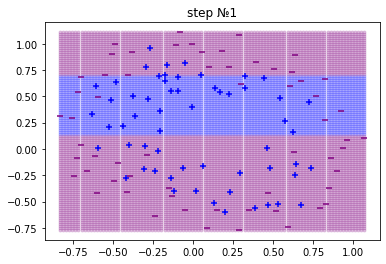

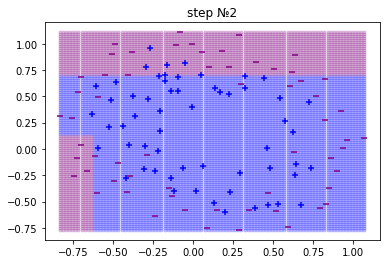

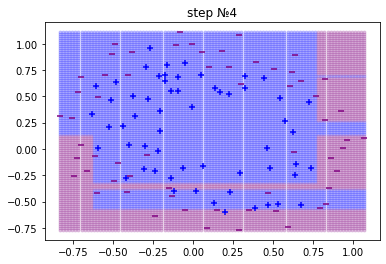

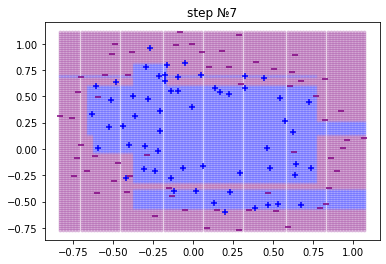

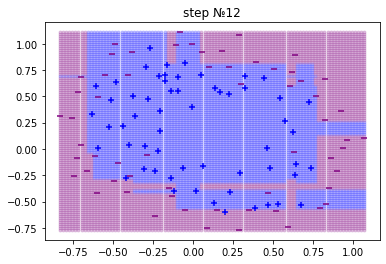

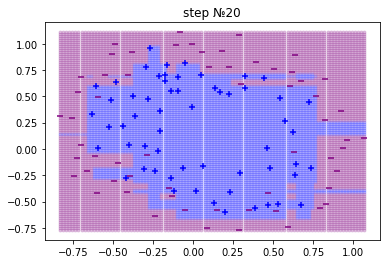

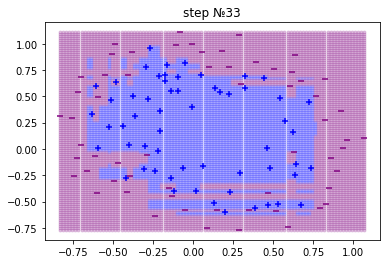

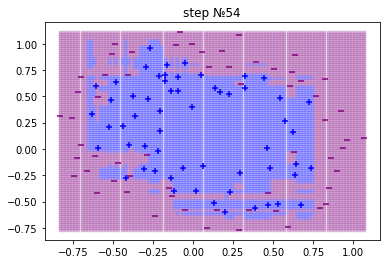

In [71]:
prcess_data('chips')

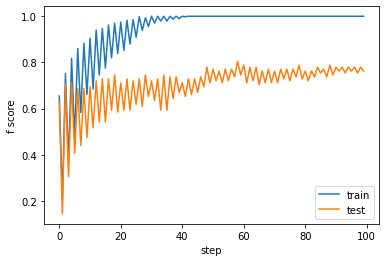

In [72]:
x_validation('chips')

### Gayser

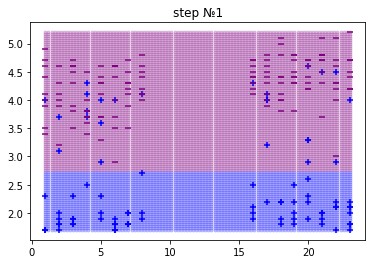

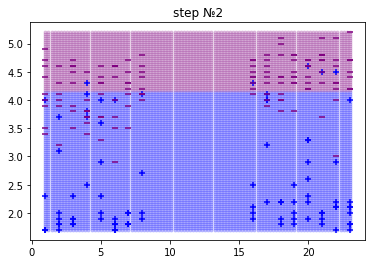

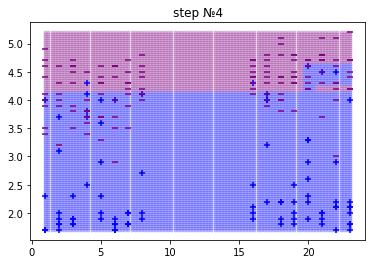

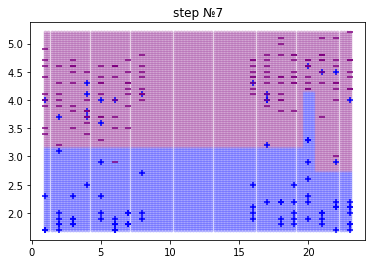

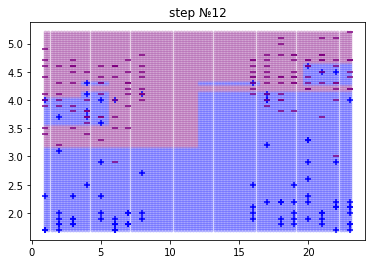

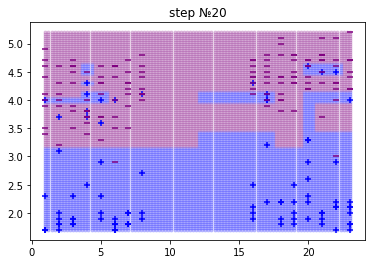

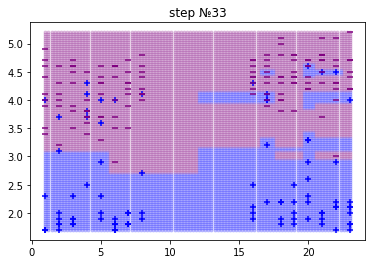

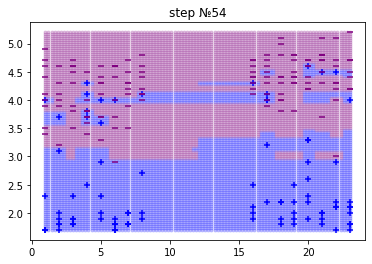

In [73]:
prcess_data('geyser')

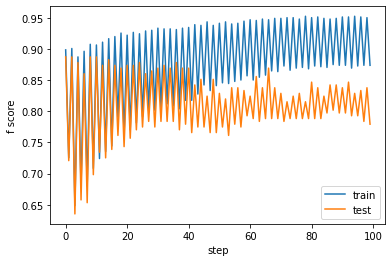

In [74]:
x_validation('geyser')